In [9]:
from control import *
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
## Using BS data for reference.
K=1000
r_L = (996+230) /1000  # length from optic to lens
r_P = (996+120+185) / 1000  # length from optic to tilt QPD
alpha = 36.9 * np.pi/180
beta = 0
r_Y = r_P * np.cos(alpha) 
theta_tilt = 2.154 * np.pi/180
theta_len = -3.09 * np.pi/180
delta_P = -0.14
delta_Y = 0.02494
f = 300/1000
C_Tx=0.004063
C_Ty=0.004534
C_Lx=0.002451
C_Ly=0.002471
def OL2EUL(r_L=r_L, r_P=r_P, r_Y=r_Y, 
           theta_tilt=theta_tilt, theta_len=theta_len, 
           alpha=alpha, beta=beta, 
           delta_Y=delta_Y, delta_P=delta_P, f=f):
    A = np.array(
            [
                [2*np.sin(beta), 2*delta_P*np.sin(beta), 2*r_Y+2*delta_Y*np.sin(beta)],
                [2*np.sin(alpha), 2*r_P+2*delta_P*np.sin(alpha), 2*delta_Y*np.sin(alpha)],
                [-2*f*np.sin(alpha)/(r_L-f), -2*delta_P*f*np.sin(alpha)/(r_L-f), -2*delta_Y*f*np.sin(alpha)/(r_L-f)]
            ])
    R = np.array(
            [
                [np.cos(theta_tilt), np.sin(theta_tilt), 0, 0],
                [-np.sin(theta_tilt), np.cos(theta_tilt), 0, 0],
                [0, 0, -np.sin(theta_len), np.cos(theta_len)]
            ]
        )
#     cal = np.array(
#             [
#                 [C_Tx, 0, 0, 0],
#                 [0, C_Ty, 0, 0],
#                 [0, 0, C_Lx, 0],
#                 [0, 0, 0, C_Ly]
#             ]
#         )
    return(np.matmul(np.linalg.inv(A), R))

# OL2EUL()[:,0], OL2EUL()[:, 2] = OL2EUL()[:, 2], OL2EUL()[:, 0].copy
# OL2EUL()[:,1], OL2EUL()[:, 3] = OL2EUL()[:, 1], OL2EUL()[:, 3].copy
# A=OL2EUL()
# # A[:,0], A[:, 2] = A[:, 2], np.copy(A[:, 0])
# # A[:,1], A[:, 3] = A[:, 3], np.copy(A[:, 1])
# A[:,0], A[:, 1] = A[:, 1], np.copy(A[:, 0])
# A[:,2], A[:, 3] = A[:, 3], np.copy(A[:, 2])
# A=A*1000
# A
# cal=np.matrix([[C_Ty,0,0,0],[0,C_Tx,0,0],[0,0,C_Ly,0],[0,0,0,C_Lx]])

# rot=K*np.matrix([[np.sin(theta_tilt),np.cos(theta_tilt),0,0],[np.cos(theta_tilt),-np.sin(theta_tilt),0,0],[0,0,np.cos(theta_len),-np.sin(theta_len)]])
# arm=np.matrix([[2*np.sin(beta),2*delta_P*np.sin(beta),2*r_Y+2*delta_Y*np.sin(beta)],[2*np.sin(alpha),2*r_P+2*delta_P*np.sin(alpha),2*delta_Y*np.sin(alpha)],[(-2*f*np.sin(alpha)/(r_L-f)),(-2*f*np.sin(alpha)/(r_L-f))*delta_P,(-2*f*np.sin(alpha)/(r_L-f))*delta_Y]])
# print(arm.I*rot*cal)
# print(np.linalg.pinv(OL2EUL()))
def LPY2QPD(L, P, Y):
    X = np.array([[L],[P],[Y]])
    return(np.matmul(np.linalg.pinv(OL2EUL()), X))



In [3]:
np.matmul(OL2EUL(),LPY2QPD(1,0,0))

array([[ 1.00000000e+00],
       [-5.85902854e-16],
       [-5.89805982e-17]])

In [82]:
f = np.linspace(0.1,10,1000)
L_tf = tf([(0.65*2*np.pi)**2],[1,0.65*2*np.pi/50,(0.65*2*np.pi)**2])
P_tf = 10*(
        tf([(0.65*2*np.pi)**2],[1,0.65*2*np.pi/50,(0.65*2*np.pi)**2])
        / tf([(0.8*2*np.pi)**2],[1,0.8*2*np.pi/100,(0.8*2*np.pi)**2])
        * tf([(0.85*2*np.pi)**2],[1,0.85*2*np.pi/100,(0.85*2*np.pi)**2])
       )
Y_tf = (
        tf([(1*2*np.pi)**2],[1,1*2*np.pi/50,(1*2*np.pi)**2])
        / tf([(1.2*2*np.pi)**2],[1,1.2*2*np.pi/100,(1.2*2*np.pi)**2])
        * tf([(1.3*2*np.pi)**2],[1,1.3*2*np.pi/100,(1.3*2*np.pi)**2])
       )
# plt.loglog(f, abs(L_tf.horner(2*np.pi*f*1j)[0][0]))
# plt.loglog(f, abs(P_tf.horner(2*np.pi*f*1j)[0][0]))
# plt.loglog(f, abs(Y_tf.horner(2*np.pi*f*1j)[0][0]))
t = np.linspace(0, 100, 10000)
input_ = np.array([gauss(0,1) for _ in t])
_, L_ts, _ = forced_response(L_tf, U=input_, T=t)
_, P_ts, _ = forced_response(P_tf, U=input_, T=t)
_, Y_ts, _ = forced_response(Y_tf, U=input_, T=t)

QPD = [
        [
            float(LPY2QPD(L_ts[i], P_ts[i], Y_ts[i])[0]),
            float(LPY2QPD(L_ts[i], P_ts[i], Y_ts[i])[1]),
            float(LPY2QPD(L_ts[i], P_ts[i], Y_ts[i])[2]),
            float(LPY2QPD(L_ts[i], P_ts[i], Y_ts[i])[3])
        ]
       for i in range(len(t))]
QPD = np.array(QPD)
x1, y1, x2, y2 = QPD[:,0], QPD[:,1], QPD[:,2], QPD[:,3]
noise = np.array([gauss(0,0.1) for _ in x1])
x1 += noise
noise = np.array([gauss(0,0.1) for _ in x1])
y1 += noise
noise = np.array([gauss(0,0.1) for _ in x1])
x2 += noise
noise = np.array([gauss(0,0.1) for _ in x1])
y2 += noise
# def 
# plt.plot(t, L_ts)
# from numpy.fft import fft, fftfreq
# L_fft = fft(L_ts)
# input_fft = fft(input_)
# freq = fftfreq(len(t), t[1]-t[0])
# mask = freq>0
# L_fft = L_fft[mask]
# input_fft = input_fft[mask]
# freq = freq[mask]
# plt.loglog(freq, abs(L_fft/input_fft))\


In [53]:
sum(np.matmul(OL2EUL(),np.array([x1,y1,x2,y2]))[2,:]-Y_ts)
# np.shape(OL2EUL())

-11.778517593829735

In [84]:
def cost(args, x1=x1, y1=y1, x2=x2, y2=y2, input_=input_, L_tf=L_tf, P_tf=P_tf, Y_tf=Y_tf, t=t):
    _OL2EUL = np.reshape(args, (3, 4))
    LPY_meas = np.matmul(_OL2EUL, np.array([x1, y1, x2, y2]))
    L_meas, P_meas, Y_meas = LPY_meas[0, :], LPY_meas[1, :], LPY_meas[2, :]
    _, L_ts, _ = forced_response(L_tf, U=input_, T=t)
    _, P_ts, _ = forced_response(P_tf, U=input_, T=t)
    _, Y_ts, _ = forced_response(Y_tf, U=input_, T=t)
    L_error = sum((L_meas-L_ts)**2)
    P_error = sum((P_meas-P_ts)**2)
    Y_error = sum((Y_meas-Y_ts)**2)
    return(L_error+P_error+Y_error)

In [85]:
from scipy.optimize import *
x0 = np.array([
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])
res = minimize(cost, x0 = x0)


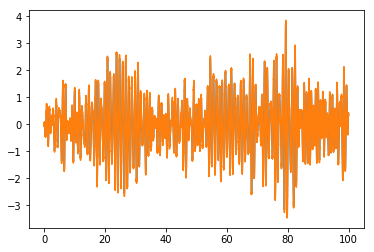

In [91]:
OL2EUL_cal=np.reshape(res.x,(3,4))
LPY_meas = np.matmul(OL2EUL_cal, np.array([x1, y1, x2, y2]))
L_meas, P_meas, Y_meas = LPY_meas[0, :], LPY_meas[1, :], LPY_meas[2, :]
plt.plot(t,Y_ts)
plt.plot(t,Y_meas)

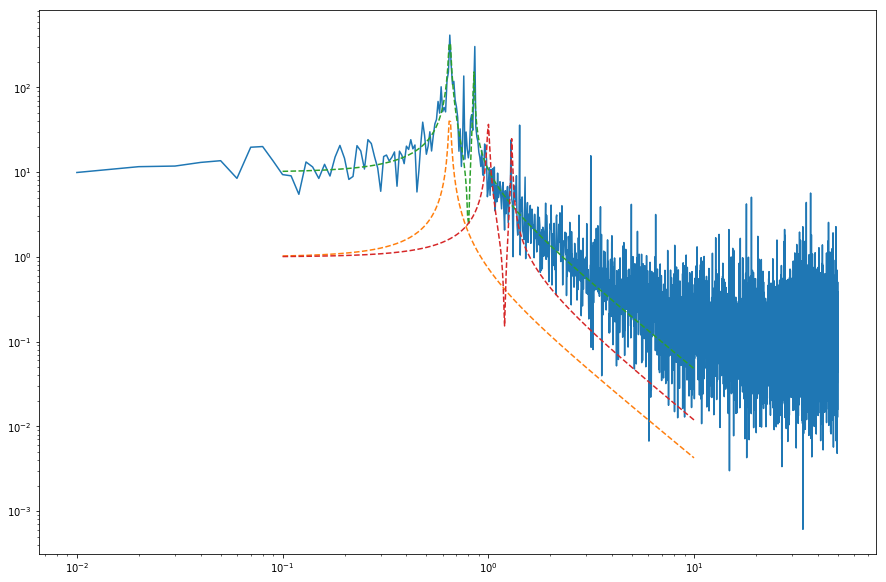

In [100]:
L_fft = fft(L_meas)
P_fft = fft(P_meas)
Y_fft = fft(Y_meas)
input_fft = fft(input_)
freq = fftfreq(len(t), t[1]-t[0])
mask = freq>0
L_fft=L_fft[mask]
P_fft=P_fft[mask]
Y_fft=Y_fft[mask]
input_fft=input_fft[mask]
freq=freq[mask]
plt.figure(figsize=(15,10))


# plt.loglog(freq, abs(L_fft/input_fft))
plt.loglog(freq, abs(P_fft/input_fft))
# plt.loglog(freq, abs(Y_fft/input_fft))
plt.loglog(f, abs(L_tf.horner(2*np.pi*f*1j)[0][0]), '--')
plt.loglog(f, abs(P_tf.horner(2*np.pi*f*1j)[0][0]), '--')
plt.loglog(f, abs(Y_tf.horner(2*np.pi*f*1j)[0][0]), '--')

In [93]:
OL2EUL_cal

array([[-1.30068654e-02,  4.88927987e-02, -7.83753642e-02,
        -1.66770483e+00],
       [-1.53088658e-02,  3.86189792e-01,  3.55513116e-02,
         8.26631307e-01],
       [ 4.79554170e-01,  1.80613527e-02,  2.05631114e-03,
         9.82045373e-05]])

In [94]:
OL2EUL()

array([[-0.0139997 ,  0.05331625, -0.12960508, -2.40084889],
       [-0.01444486,  0.3840482 ,  0.06394517,  1.18454225],
       [ 0.48024955,  0.0180632 ,  0.        ,  0.        ]])